In [1]:
print("hello world")

hello world


In [2]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms # .v2 as transforms
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.ops import sigmoid_focal_loss
from torch.amp import GradScaler

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics, print_training_statistics
from classes.RetinaDataset import RetinaDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Transformation & Augmentation

In [3]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

mean = np.array(mean, dtype=np.float32, copy=True)  # Copie explicite
std = np.array(std, dtype=np.float32, copy=True)

mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


densenet121 gets 256*256 tensors

In [4]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

# Single augmentation transform with random applications
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15)  # Reduced from 30 to preserve medical image integrity
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

## 2. Data Loading

In [5]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented,  # Use augmented transform with random applications
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

## 3. DenseNet121 definition

In [6]:
NUMBER_OF_LABELS = 4

model = densenet121(weights=DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, NUMBER_OF_LABELS) 
model = model.to(device)

for param in model.parameters(): # first layers frozen
    param.requires_grad = False
for param in model.classifier.parameters(): # last layer trainable
    param.requires_grad = True

## 4. Loss definition

In [7]:
alpha = 0.25  # penalisation of minor classes
gamma = 2.0   # focusing parameter for modulating factor (1-p) to reduce the relative loss for well-classified examples, putting more focus on hard, misclassified examples
criterion = lambda outputs, labels: sigmoid_focal_loss(
    outputs, labels, alpha=alpha, gamma=gamma, reduction='mean'
) # equivalent to nn.BCEWithLogitsLoss() when alpha=1 and gamma=0
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = GradScaler()  # For Automatic Mixed Precision

## 5. Model training

In [8]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_test_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 2 

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device,
        num_labels=NUMBER_OF_LABELS,
        scaler=scaler)
    
    # Print metrics
    print_training_statistics(
        train_loss, train_accuracy, train_f1, train_roc_auc, 
        test_loss, test_accuracy, test_f1, test_roc_auc,
        get_device_properties=True, memory_allocated=True, memory_reserved=True
    )

    
    # Early stopping
    scheduler.step(test_loss) 
    if epoch > 15:
        if (best_test_loss - test_loss) > min_delta:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)



Epoch number: 0


100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1202 | Train Accuracy: 0.5224 | Train F1-score: 0.3344 | Train ROC-AUC: 0.5058 |
| Test Loss:  0.0946 | Test Accuracy:  0.5866 | Test F1-score:  0.3405 | Test ROC-AUC:  0.5419 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 1


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0771 | Train Accuracy: 0.6671 | Train F1-score: 0.2168 | Train ROC-AUC: 0.5385 |
| Test Loss:  0.0689 | Test Accuracy:  0.6939 | Test F1-score:  0.1824 | Test ROC-AUC:  0.5840 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------


In [11]:
torch.save(model.state_dict(), '../Models/model_ft_densenet121_mcmlc.pth')

In [12]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_model_ft_densenet121_mcmlc.csv', index=False)

## 6. Evolution of the training

In [13]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_model_ft_densenet121_mcmlc.csv')

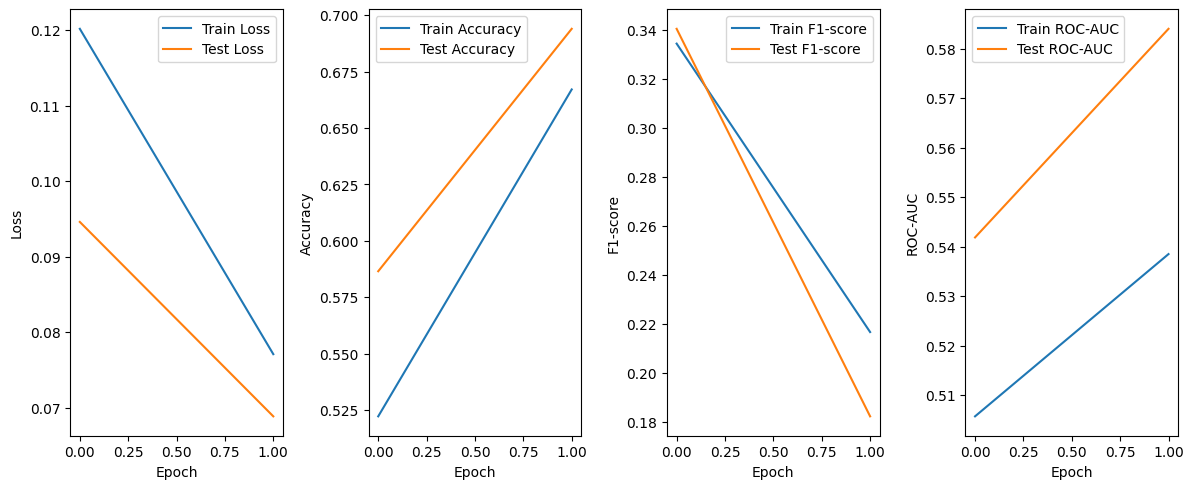

In [14]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_densenet121_mcmlc_zoomed.png',
    title='Training Evolution - Fine Tuned DenseNet121 Multi-Class Multi-Labeling Zoomed',
    zoomed=True
)


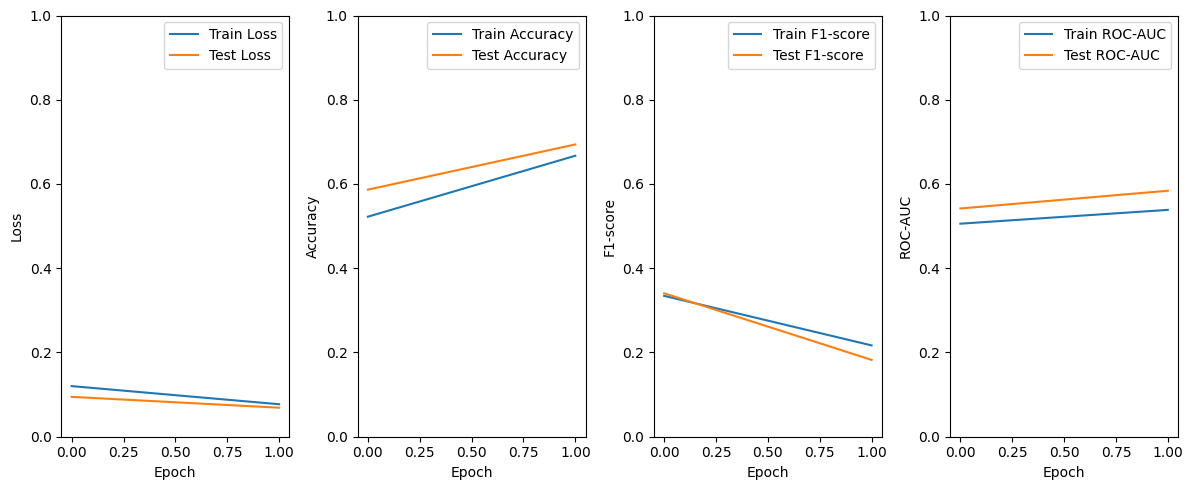

In [15]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_densenet121_mcmlc.png',
    title='Training Evolution - Fine Tuned DenseNet121 Multi-Class Multi-Labeling',
    zoomed=False
)


## 7. Model evaluation

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUMBER_OF_LABELS = 4 

model = densenet121(weights=DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 
model.load_state_dict(torch.load('../Models/model_ft_densenet121_mcmlc.pth', weights_only=True))
alpha = 0.25  
gamma = 2.0   
criterion = lambda outputs, labels: sigmoid_focal_loss(
    outputs, labels, alpha=alpha, gamma=gamma, reduction='mean'
) 

In [17]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device=device, num_labels=NUMBER_OF_LABELS)

In [18]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.0709 | Validation Accuracy: 0.7089 | Validation F1-score: 0.1850 | Validation ROC-AUC: 0.5947
